# DAT210x - Programming with Python for DS

## Module5- Lab5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

matplotlib.style.use('ggplot') # Look Pretty

### A Convenience Function

In [2]:
def plotDecisionBoundary(model, X, y):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    padding = 0.6
    resolution = 0.0025
    colors = ['royalblue','forestgreen','ghostwhite']

    # Calculate the boundaris
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= x_range * padding
    y_min -= y_range * padding
    x_max += x_range * padding
    y_max += y_range * padding

    # Create a 2D Grid Matrix. The values stored in the matrix
    # are the predictions of the class at at said location
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                       np.arange(y_min, y_max, resolution))

    # What class does the classifier say?
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour map
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.terrain)

    # Plot the test original points as well...
    for label in range(len(np.unique(y))):
        indices = np.where(y == label)
        plt.scatter(X[indices, 0], X[indices, 1], c=colors[label], label=str(label), alpha=0.8)

    p = model.get_params()
    plt.axis('tight')
    plt.title('K = ' + str(p['n_neighbors']))

### The Assignment

Load up the dataset into a variable called `X`. Check `.head` and `dtypes` to make sure you're loading your data properly--don't fail on the 1st step!

In [3]:
X = pd.read_csv('Datasets/wheat.data', index_col=0) # Si no se especifica index_col=0 el ejercicio sale mal porque incluye la columna indice dentro de los datos de entrenamiento.
print(X.head(5))
print(X.dtypes)

     area  perimeter  compactness  length  width  asymmetry  groove wheat_type
id                                                                            
0   15.26      14.84       0.8710   5.763  3.312      2.221   5.220       kama
1   14.88      14.57       0.8811   5.554  3.333      1.018   4.956       kama
2   14.29      14.09       0.9050   5.291  3.337      2.699   4.825       kama
3   13.84      13.94       0.8955   5.324  3.379      2.259   4.805       kama
4   16.14      14.99       0.9034   5.658  3.562      1.355   5.175       kama
area           float64
perimeter      float64
compactness    float64
length         float64
width          float64
asymmetry      float64
groove         float64
wheat_type      object
dtype: object


Copy the `wheat_type` series slice out of `X`, and into a series called `y`. Then drop the original `wheat_type` column from the `X`:

In [4]:
y = X.wheat_type
X = X.drop(['wheat_type'], axis=1)
print(X.head(5))

     area  perimeter  compactness  length  width  asymmetry  groove
id                                                                 
0   15.26      14.84       0.8710   5.763  3.312      2.221   5.220
1   14.88      14.57       0.8811   5.554  3.333      1.018   4.956
2   14.29      14.09       0.9050   5.291  3.337      2.699   4.825
3   13.84      13.94       0.8955   5.324  3.379      2.259   4.805
4   16.14      14.99       0.9034   5.658  3.562      1.355   5.175


Do a quick, "ordinal" conversion of `y`. In actuality our classification isn't ordinal, but just as an experiment...

In [5]:
# Look two methods available in Feature Representation reading part
y = y.astype('category').cat.codes # Method 1

# y = pd.get_dummies(y, columns=['wheat_type']) # Method 2. Si se hace por este método se divide en tres columnas.
y.head(10)

id
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    0
8    1
9    1
dtype: int8

Do some basic nan munging. Fill each row's nans with the mean of the feature:

In [6]:
print(X.isnull().sum()) # Para ver dónde hay valores NA y cuántos –> compactness (3), width (1) y groove (4)
print(y.isnull().sum()) # Idem. –> 0

X.compactness.fillna(X.compactness.mean(), inplace = True) # Ver en Wrangling Your Data. Inplace=True necesario para reemplazarlo.
X.width.fillna(X.width.mean(), inplace = True)
X.groove.fillna(X.groove.mean(), inplace = True)

print(X.isnull().sum())
print(X.min(), X.max()) # Para ver que no se había rellenado nada con un número absurdo.


area           0
perimeter      0
compactness    3
length         0
width          1
asymmetry      0
groove         4
dtype: int64
0
area           0
perimeter      0
compactness    0
length         0
width          0
asymmetry      0
groove         0
dtype: int64
area           10.5900
perimeter      12.4100
compactness     0.8081
length          0.8189
width           2.6300
asymmetry       0.7651
groove          3.4850
dtype: float64 area           21.1800
perimeter      17.2500
compactness     0.9183
length          6.6750
width           5.3250
asymmetry       8.4560
groove          6.7350
dtype: float64


Split `X` into training and testing data sets using `train_test_split()`. Use `0.33` test size, and use `random_state=1`. This is important so that your answers are verifiable. In the real world, you wouldn't specify a random_state:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1)

Create an instance of SKLearn's Normalizer class and then train it using its .fit() method against your _training_ data. The reason you only fit against your training data is because in a real-world situation, you'll only have your training data to train with! In this lab setting, you have both train+test data; but in the wild, you'll only have your training data, and then unlabeled data you want to apply your models to.

In [8]:
T = preprocessing.Normalizer().fit(X_train)

With your trained pre-processor, transform both your training AND testing data. Any testing data has to be transformed with your preprocessor that has ben fit against your training data, so that it exist in the same feature-space as the original data used to train your models.

In [9]:
X_train_t = T.transform(X_train)
X_test_t = T.transform(X_test)

Just like your preprocessing transformation, create a PCA transformation as well. Fit it against your training data, and then project your training and testing features into PCA space using the PCA model's `.transform()` method. This has to be done because the only way to visualize the decision boundary in 2D would be if your KNN also ran in 2D as well:

In [10]:
PCAmodel = PCA(n_components=2, svd_solver='randomized')
PCAmodel.fit(X_train_t)

PCA_X_train = PCAmodel.transform(X_train_t)
PCA_X_test = PCAmodel.transform(X_test_t)

Create and train a KNeighborsClassifier. Start with `K=9` neighbors. Be sure train your classifier against the pre-processed, PCA- transformed training data above! You do not, of course, need to transform your labels.

In [11]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(PCA_X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

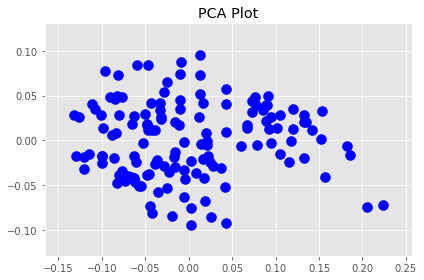

In [12]:
plt.scatter(PCA_X_train[:,0], PCA_X_train[:,1], s=100, color='blue')
plt.title('PCA Plot')
plt.tight_layout()
plt.show()

In [13]:
# I hope your KNeighbors classifier model from earlier was named 'knn'
# If not, adjust the following line:
plotDecisionBoundary(knn, PCA_X_train, y_train)

Display the accuracy score of your test data/labels, computed by your KNeighbors model. You do NOT have to run `.predict` before calling `.score`, since `.score` will take care of running your predictions for you automatically.

In [14]:
knn.score(PCA_X_test, y_test)

0.87142857142857144

### Bonus

Instead of the ordinal conversion, try and get this assignment working with a proper Pandas get_dummies for feature encoding. You might have to update some of the `plotDecisionBoundary()` code.

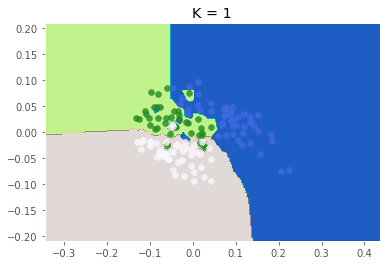

In [15]:
plt.show()